# Magnipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Magnipy` package, which is used to **compute and compare the magnitude (effective size) of point clouds.**

## Importing Packages and Datasets

Before we begin, we must import the packages required for our functionality. Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# import statements for external packages
from importlib import reload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
# import statements from magnipy repo
from magnipy.magnipy import Magnipy
from tutorial_data import *

We create 3 example datasets according to different distributions, each with 1000 points.

1. **Random Point Cloud from Uniform Distribution**  
Here, we generate random points in a 3D space (i.e. selecting points according to a uniform distribution so that any point is chosen with equal probability.)

2. **Clusters/Blobs**  
Here, we generate a dataset clustered around 5 points.

3. **The Swiss Roll**  
The Swiss Roll is a classic generated dataset that roughly takes the shape of a 2D plane that has been rolled in a spiral, forming a 3D manifold. Here, we use it as a toy example to demonstrate the functionality of our magnipy package.

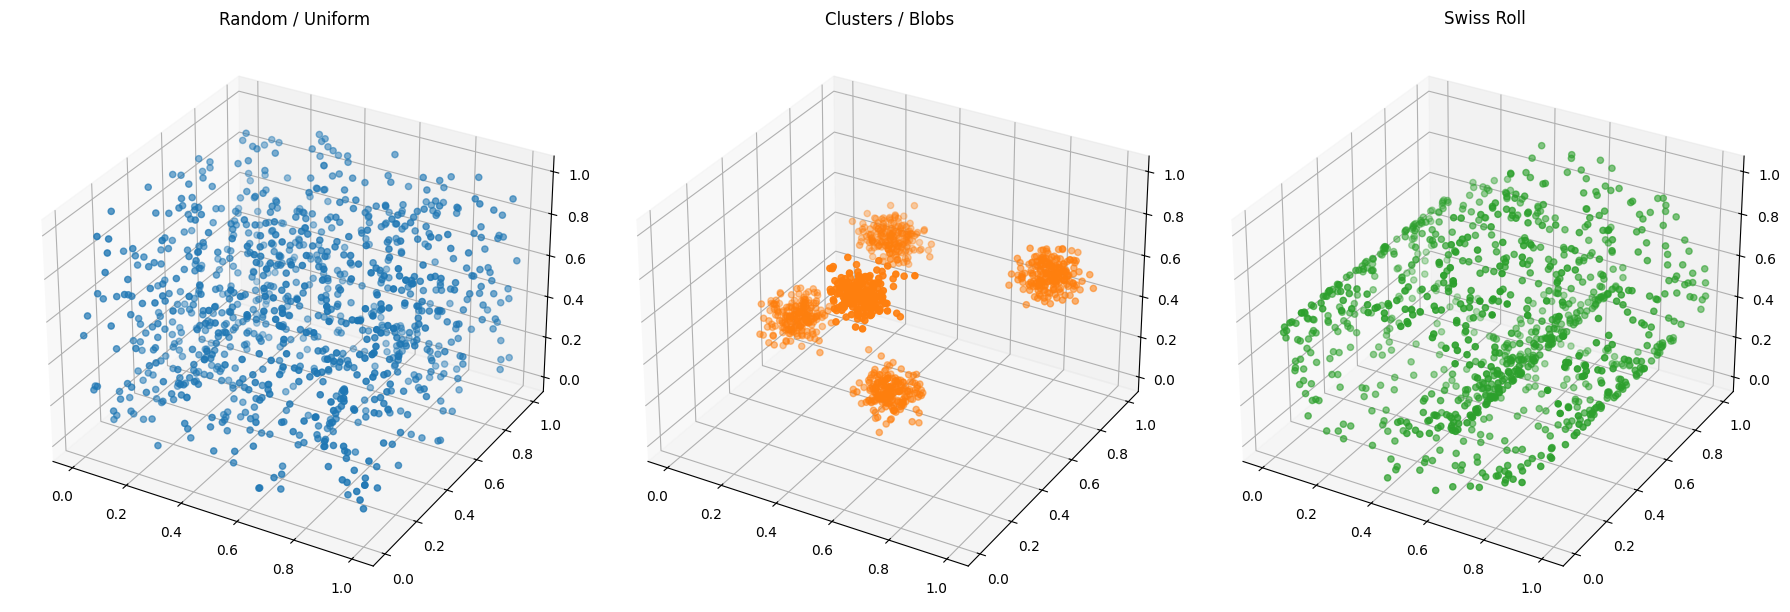

In [2]:
# Grabbing datasets
rando_data, rando_df = get_random()
blobs_data, blobs_df = get_clusters()
sr_data, sr_df = get_swiss_roll()
# Plotting
plot_dfs([rando_df, blobs_df, sr_df], titles=["Random / Uniform", "Clusters / Blobs", "Swiss Roll"])

## Computing Magnitude

To compute magnitude, we first create the `Magnipy` object for each datset, which we will use to call our magnitude methods.

In [3]:
# Creating a Magnipy instance for each dataset
rando = Magnipy(rando_data, name='Random')
blobs = Magnipy(blobs_data, name='Clustered/Blobs')
swiss_roll = Magnipy(sr_data, name='Swiss Roll')
mags = [rando, blobs, swiss_roll]

We can now call the Magnipy methods on each of these instances. Computing and visualizing the magnitude across distance scales is as simple as calling the `plot_magnitude_function()` method.

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

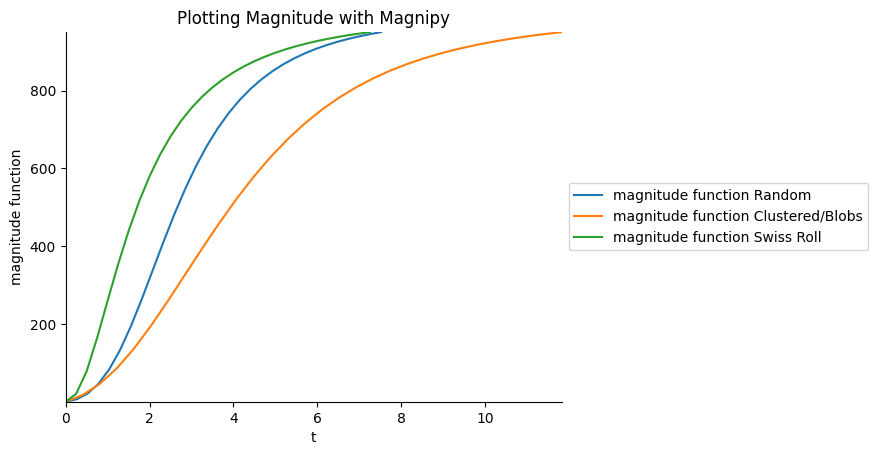

In [4]:
# Plotting magnitude
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

Recall that **t** is our distance scaling factor. This means any pairwise distance between points is scaled by a factor of t. We can visualize an increase in **t** as 'zooming in', where points spread further away from each other.

When **t** is 0, the points have distance 0 from each other, and thus are effectively 1 point. As **t** increases, we 'zoom in' and the distance between points increases as they spread out. Thus the magnitude / effective size also increases. Finally, **t** plateaus at the cardinality of the dataset, in this case 1000.

By default, we compute magnitude until it reaches 95% of the cardinality. (See section _"Determining Convergence Scales and Evaluation Intervals"_ below).

## Zooming In: Breakdown of Magnitude Pipeline

How does Magnipy compute magnitude? In this section, we walk through the process step by step:

1. Computing the Distance Matrix
2. Creating the Similarity Matrix
3. Determining Convergence Scales and Evaluation Intervals
4. Computing Magnitude Weights
5. Aggregating for Overall Magnitude

### 1. Computing the Distance Matrix

Recall the **t** is a scaling factor for the distance between points in the metric space. We compute a distance matrix that stores the pairwise distances between points in the metric space. (The dimensions of this matrix are |X| by |X|). This can then be easily scaled by our scaling factor **t**.

In [5]:
# Computing distance matrix with get_dist()
rando_dist = rando.get_dist()
blob_dist = blobs.get_dist()
swiss_dist = swiss_roll.get_dist()

We can visualize these distance matrices below, with the x- and y- axes representing the index of each point in the dataset. Note that distance when x=y (i.e. distance between a point and itself) is always 0.

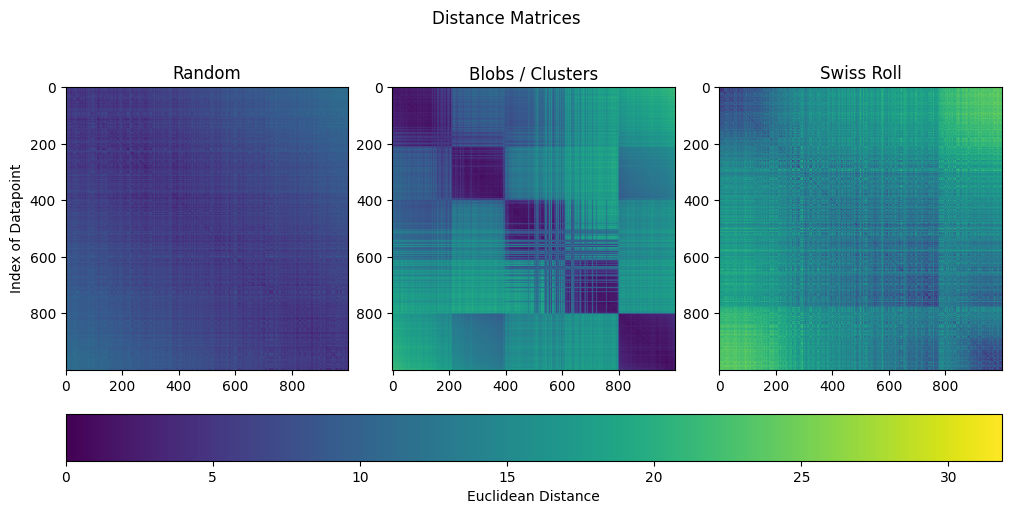

In [6]:
# Visualization of distance matrices
plot_matrix_heatmaps([rando_dist, blob_dist, swiss_dist], distance=True)

##### Customizing Distance Calculation

When initializing the Magnipy object, you can customize which distance metric you want to use. The default is to use Euclidean distance. See `magnipy.py` for a complete list of all supported metrics.

### 2. Creating the Similarity Matrix

The distance ($d$) and similarity ($\zeta$) of two points _a_ and _b_ are related in the following way: $\zeta(a, b) = e^{(-d(a,b))}$

Practically speaking, this means that two points separated by a distance of 0 (i.e. are the same) have a **similarity of 1**. Conversely, two points theoretically separated by an infinite distance would have a **similarity of 0**. This relationship, in which **similarities decrease exponentially as distances increase,** emphasizes the influence of close neighbors / very similar pairs of points.

In [7]:
# Computing similarity matrices
rando_sim = rando.get_similarity_matrix()
blobs_sim = blobs.get_similarity_matrix()
swiss_sim = swiss_roll.get_similarity_matrix()

We can visualize these similarity matrices similarly to how we visualized distance. Recall that **all similarity values fall between 0 and 1**, while distances are dependent on the size of metric space.

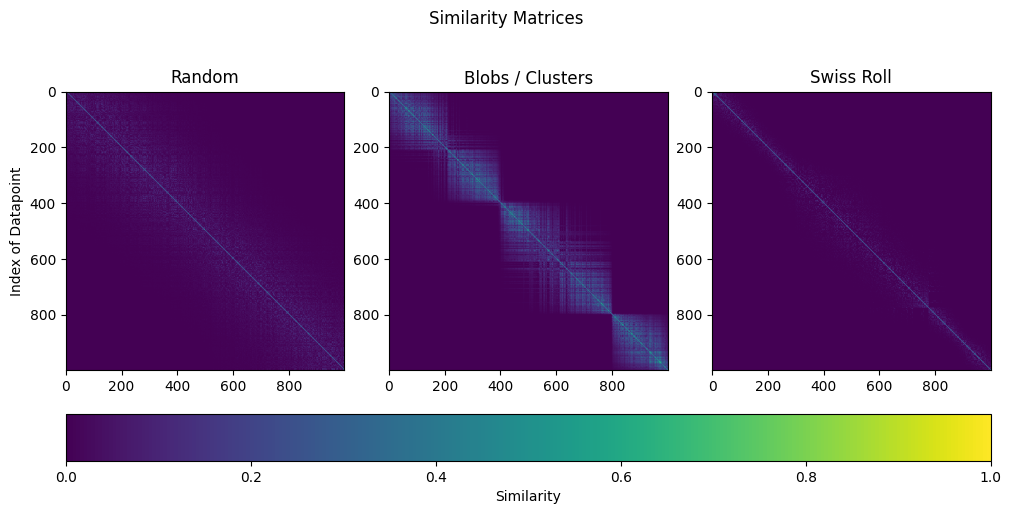

In [8]:
# Visualizing similarity matrices
plot_matrix_heatmaps([rando_sim, blobs_sim, swiss_sim], distance=False)

### 3. Determining Convergence Scales and Evaluation Intervals

**_Q: How does Magnipy decide which values of **t** to compute magnitude for?_**  

We define each Magnipy object's **evaluation interval** as the range of t values over which magnitude should be calculated. This can be determined automatically by Magnipy or be customized by the user.

**Automatic Computation by Magnipy (Default)**

Magnipy can compute a suitable evaluation interval automatically by taking the interval from zero until the spaces's **convergence scale** (i.e. when the magnitude will reach 95% of the space's cardinality) and dividing it evenly into `n_ts` values (default=100).

In [9]:
# Get evaluation interval for dataset with .get_scales()
rando_ts = rando.get_scales()
print(f"Evaluation interval for Random Dataset: [{rando_ts[0]:.2f}, {rando_ts[1]:.2f}, {rando_ts[2]:.2f}, ..., {rando_ts[-1]:.2f}].")

# Get convergence scale for datasets with .get_t_conv()
rando_conv = rando.get_t_conv()
print(f"Notice that the last value of the evaluation interval is the same as the convergence scale: {rando_conv:.2f}")

Evaluation interval for Random Dataset: [0.00, 0.26, 0.52, ..., 7.52].
Notice that the last value of the evaluation interval is the same as the convergence scale: 7.52


**User Customization**

There are several ways for the user to **customize how evaluation scales are computed** when creating a Magnipy object, including:

- Manually entering t values via the `ts` parameter (default = None)
- Altering the number of t values via the `n_ts` parameter (default = 100)
- Using a log scale by setting `log_scale = True` (default = False)
- Changing the proportion of cardinality the magnitude function converges to via `target_prop` (default = 0.95)
- Changing the method from "convergence" to "scattered" via the `scale_finding` parameter (default = "convergence")

See the `magnipy.py` file for descriptions of all evaluation scale parameters.

### 4. Computing Magnitude Weights

Before finding the magnitude of the whole space at each time scale, we first compute the **magnitude weights** for each of point at each time scale. The magnitude weight of a point can roughly be thought of as "how dissimilar" it is to other points. The more dissimilar (i.e further) it is from surrounding points, the greater its magnitude weight. The magnitude weight can also be thought of as **the amount that each point contributes to the overall magnitude of the metric space**, which is simply the sum of the magnitude weights of all points.

Magnitude weights can be computed according to several different methods. You can select your preferred method via the `method` parameter when initializing a Magnipy object (**default = "cholesky"**).

In [10]:
# Computing magnitude weights with get_magnitude_weights() method
rando_weights, rando_ts = rando.get_magnitude_weights()
blobs_weights, blobs_ts = blobs.get_magnitude_weights()
swiss_weights, swiss_ts = swiss_roll.get_magnitude_weights()

# X_weights.shape = (1000=|X|, 30=n_ts)
# X_ts.shape = (30=n_ts, )

[7, 14, -1]
[7, 14, -1]
[7, 14, -1]
[7, 14, -1]
[7, 14, -1]
[7, 14, -1]
[7, 15, -1]
[7, 15, -1]
[7, 15, -1]


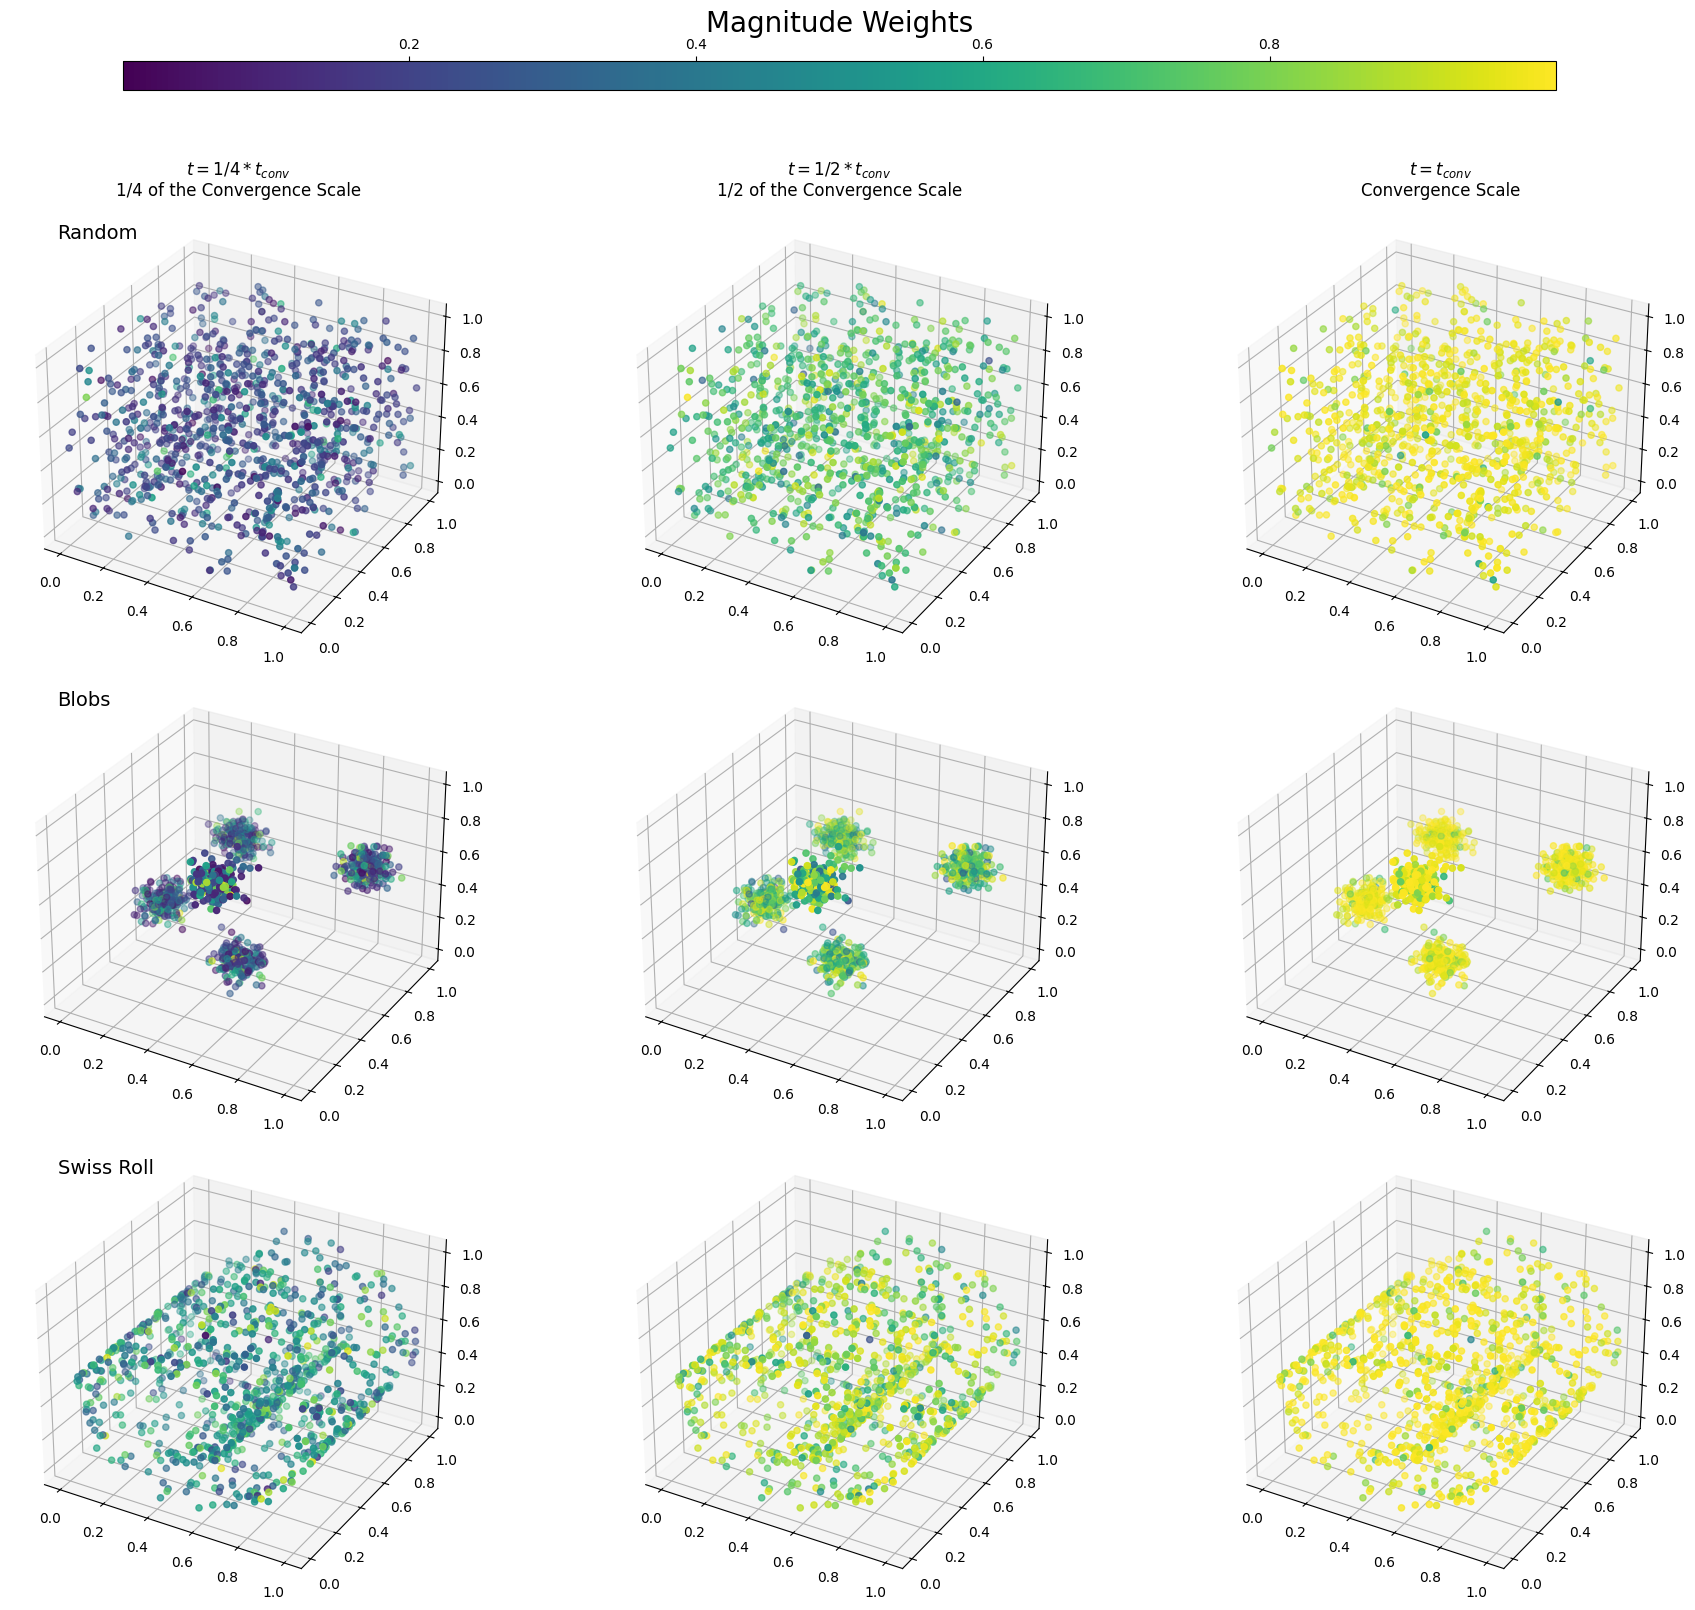

In [11]:
# Plotting magnitude weights
plot_weights(
    [rando_df, blobs_df, sr_df],
    [rando_ts, blobs_ts, swiss_ts],
    [rando_weights, blobs_weights, swiss_weights],
    ["Random", "Blobs", "Swiss Roll"],
)

Note that the magnitude weight of each point **increases monotonically** as the scaling factor increases, and always falls between 0 and 1. Thus the overall magnitude (i.e. sum of all magnitude weights) is at most the cardinality of the dataset, as desired.

### 5. Aggregating for Overall Magnitude

The overall magnitude of a space at scaling factor **t** is simply the sum of the individual magnitude weights at scaling factor **t**. Since individual magnitude weights increase monotonically with **t**, so does the overall magnitude.

In [12]:
# Getting magnitude values
rando_magnitude_vals, rando_t_vals = rando.get_magnitude()
blobs_magnitude_vals, blobs_t_vals = blobs.get_magnitude()
swiss_magnitude_vals, swiss_t_vals = swiss_roll.get_magnitude()

show_magnitude_table([rando_magnitude_vals, blobs_magnitude_vals, swiss_magnitude_vals], [rando_t_vals, blobs_t_vals, swiss_t_vals])

Random Dataset 		Blobs Dataset 			Swiss Roll Dataset
t 	 Magnitude 	t 	 Magnitude 	t 	 Magnitude
0.00 	 1.00    	0.00 	 1.00     	 0.00 	 1.00
0.26 	 7.31    	0.41 	 18.27     	 0.25 	 21.21
0.52 	 21.64    	0.82 	 47.05     	 0.50 	 79.11
0.78 	 46.55    	1.22 	 87.09     	 0.75 	 164.99
1.04 	 83.83    	1.63 	 137.72     	 1.00 	 260.42
1.30 	 133.82    	2.04 	 196.73     	 1.25 	 353.84
1.56 	 195.10    	2.45 	 261.30     	 1.50 	 439.48
1.81 	 264.58    	2.85 	 328.52     	 1.75 	 515.02
2.07 	 338.25    	3.26 	 395.78     	 2.00 	 580.13
2.33 	 412.10    	3.67 	 460.92     	 2.25 	 635.55
2.59 	 482.82    	4.08 	 522.32     	 2.50 	 682.45
2.85 	 548.16    	4.48 	 578.93     	 2.75 	 722.07
3.11 	 606.92    	4.89 	 630.17     	 3.00 	 755.58
3.37 	 658.74    	5.30 	 675.89     	 3.25 	 784.01
3.63 	 703.81    	5.71 	 716.22     	 3.50 	 808.22
3.89 	 742.65    	6.11 	 751.50     	 3.75 	 828.92
4.15 	 775.95    	6.52 	 782.18     	 4.00 	 846.71
4.41 	 804.41    	6.93 	 808.75    

Here we can confirm that the default evaluation interval computed by Magnipy stops when the magnitude reaches 95% of the cardinality (95% of 1000 = 950).

These values above are what are drawn upon when we plot magnitude functions.

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

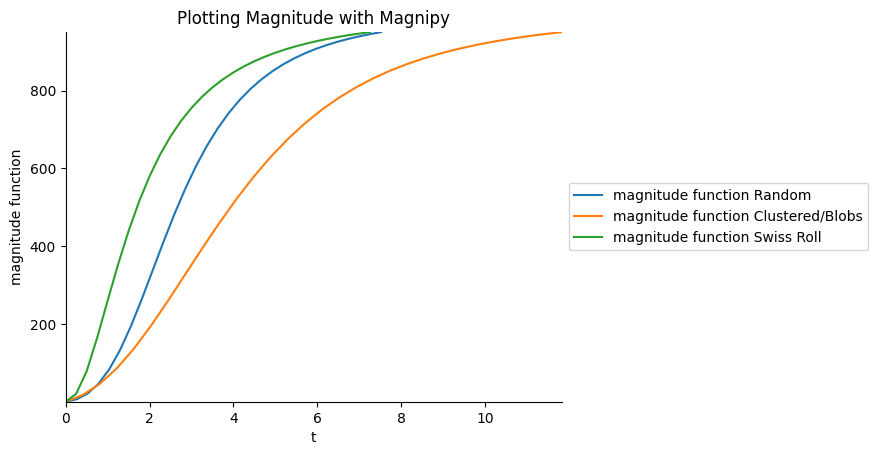

In [13]:
# Plotting magnitude again
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

###  Nice work! We have come full circle.

This concludes the Magnipy tutorial.

To investigate how magnitude can act as a metric for quantifying the diversity of a metric space, please see our Diversipy Tutorial (`diversipy_tutorial.ipynb`).